In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin ,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

In [101]:
data=pd.read_csv('/content/diabetes (3).csv')
data.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
528,0,117,66,31,188,30.8,0.493,22,0
174,2,75,64,24,55,29.7,0.370,33,0
11,10,168,74,0,0,38.0,0.537,34,1
138,0,129,80,0,0,31.2,0.703,29,0
656,2,101,58,35,90,21.8,0.155,22,0
485,0,135,68,42,250,42.3,0.365,24,1
618,9,112,82,24,0,28.2,1.282,50,1
298,14,100,78,25,184,36.6,0.412,46,1
750,4,136,70,0,0,31.2,1.182,22,1
275,2,100,70,52,57,40.5,0.677,25,0


In [102]:
cor=data.corr()
cor

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


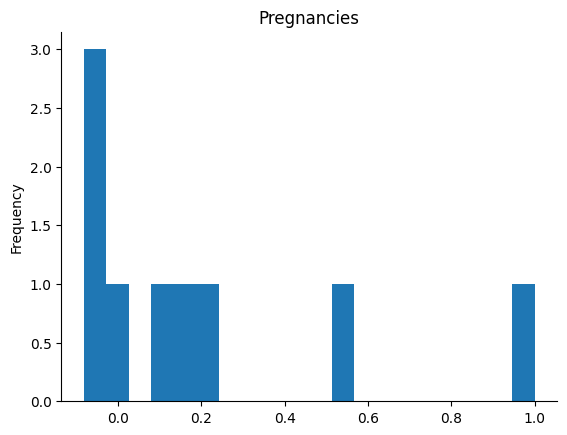

In [103]:
# @title Pregnancies

from matplotlib import pyplot as plt
cor['Pregnancies'].plot(kind='hist', bins=20, title='Pregnancies')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [104]:
x=data.drop(['Outcome','SkinThickness','BloodPressure'],axis=1)
y=data['Outcome']

In [105]:
class ZeroToNaN(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return np.where(X == 0, np.nan, X)

In [106]:
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.bounds_ = {}
        for col in X.columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            self.bounds_[col] = (lower, upper)
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            lower, upper = self.bounds_[col]
            if (X[col] < lower).any() or (X[col] > upper).any():
                X[col] = X[col].clip(lower, upper)
        return X


In [107]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        for i in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(linear_model)
            dw = (1 / num_samples) * np.dot(X.T, (predictions - y))
            db = (1 / num_samples) * np.sum(predictions - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        return self

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def accuracy_score(self, y_predicted, y_actual):
        return np.mean(y_predicted == y_actual)


In [108]:
replcae=['Glucose','Insulin']
clip=['BMI','DiabetesPedigreeFunction','Age']
main=np.array(x.columns)


In [109]:
preprocessing=ColumnTransformer([
    ('zerotonan',ZeroToNaN(),replcae),
    ('outliercapper',OutlierCapper(),clip),
    ('std_scaler',StandardScaler(),main)],
    remainder='passthrough'
)

In [121]:
pipe=Pipeline([
    ('preprocessing',preprocessing),
    ('model',LogisticRegression(learning_rate=0.1, num_iterations=1000))
])

In [122]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zerotonan', ZeroToNaN(),
                                                  ['Glucose', 'Insulin']),
                                                 ('outliercapper',
                                                  OutlierCapper(),
                                                  ['BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  array(['Pregnancies', 'Glucose', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'], dtype=object))])),
                ('model', LogisticRegression(learning_rate=0.1))])

In [123]:
y_pred=pipe.predict(x_test)

In [124]:
pipe['model'].accuracy_score(y_pred,y_test)

np.float64(0.6536796536796536)

In [127]:
scores=cross_val_score(pipe,x,y,cv=5)

In [128]:
print(scores)

[0.64935065 0.58441558 0.62987013 0.74509804 0.64705882]


In [129]:
import pickle



with open("model.pkl", "wb") as f:
    pickle.dump(pipe, f)
